# Word2Vec

## CBOW モデル

In [1]:
import numpy as np
from abc import ABCMeta, abstractmethod


class MLPLayer(metaclass=ABCMeta):
    @abstractmethod
    def forward(self):
        pass
    
    @abstractmethod
    def backward(self):
        pass


class MatMulIn(MLPLayer):
    def __init__(self, W):
        self.W = W
        self.dW = None
        self.A_list = []
    
    def forward(self, A_list, is_training=False):
        out = np.zeros((A_list[0].shape[0], self.W.shape[1]))
        for A in A_list:
            out += np.dot(A, self.W)
        out /= len(A_list)
        if is_training:
            self.A_list = A_list
        return out
    
    def backward(self, dout):
        #dA = np.dot(dout, self.W)
        dA = np.dot(dout, self.W.T)
        self.dW = np.zeros(self.W.shape)
        for A in self.A_list:
            self.dW += np.dot(dout.T, A).T
        self.dW /= len(self.A_list)
        return dA

    
class MatMulOut(MLPLayer):
    def __init__(self, W):
        self.W = W
        self.dW = None
        self.A = None
    
    def forward(self, A, is_training=False):
        out = np.dot(A, self.W)
        if is_training:
            self.A = A
        return out
    
    def backward(self, dout):
        #dA = np.dot(dout, self.W)
        dA = np.dot(dout, self.W.T)
        self.dW = np.dot(dout.T, self.A).T
        
        self.A = None
        return dA


class Affine(MLPLayer):
    def __init__(self, W, b):
        # モデルの重み
        self.W = W
        self.b = b
        # 重みの勾配
        self.dW = None
        self.db = None
        # Adam 用パラメータ
        self.v_W = np.zeros(W.shape)
        self.v_b = np.zeros(b.shape)
        self.h_W = np.zeros(W.shape)
        self.h_b = np.zeros(b.shape)
        # 誤差逆伝播用の中間データ
        self.A = None

    def forward(self, A, is_training=False):
        out = np.dot(A, self.W.T) + self.b
        
        if is_training:
            self.A = A
        return out

    def backward(self, dout):
        dA = np.dot(dout, self.W)
        self.dW = np.dot(dout.T, self.A)
        self.db = dout.sum(axis=0)
        
        self.A = None
        return dA


class SoftMax(MLPLayer):
    def __init__(self):
        # 誤差逆伝播用の中間データ
        self.Y = None
    
    def forward(self, Z, is_training=False):
        Z_exp = np.exp(Z)
        Y = (Z_exp.T / Z_exp.sum(axis=1)).T
        
        if is_training:
            self.Y = Y
        return Y
    
    def backward(self, dout):
        dZ = self.Y * (dout.T - np.sum(self.Y * dout, axis=1)).T
        
        self.Y = None
        return dZ


class CostCalculation(MLPLayer):
    def __init__(self):
        # 誤差逆伝播用の中間データ
        self.Y_predict = None
        self.Y_correct = None
    
    def forward(self, Y_predict, Y_correct, is_training=False):
        cost = - np.sum(Y_correct * np.log(Y_predict) + (1.0 - Y_correct) * np.log(1.0 - Y_predict), axis=1)
        cost = np.average(cost)
        
        if is_training:
            self.Y_predict = Y_predict
            self.Y_correct = Y_correct
        return cost
    
    def backward(self, dout=1.0):
        batch_size = self.Y_predict.shape[0]
        dA = (self.Y_predict - self.Y_correct) / (self.Y_predict * (1.0 - self.Y_predict)) / batch_size
        
        self.Y_predict = None
        self.Y_correct = None
        return dA

0 5.08761368994783
100 2.2873474098199695
200 1.9638422770270292
300 1.855970732682135
400 1.813344142754579
500 1.7911205996989479
600 1.7794971592210873
700 1.7734369246666375
800 1.7699963461606263
900 1.7678204917178715


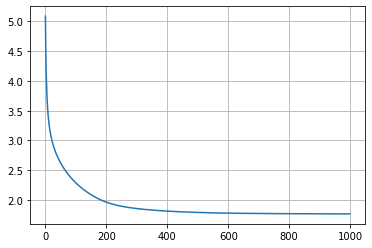

I	[ 2.44417187 -0.16361257  1.54876979 -0.09574359  1.68049699]
say	[-1.48061798 -1.2480011   1.11905655 -0.51744905 -1.9751576 ]
hello	[-0.19484317  1.16595252 -0.16848114 -1.58234769  2.42925657]
.	[-2.40291285 -0.11185574 -0.26385354 -1.24729914 -1.1322048 ]
You	[ 0.16016848  0.65640077 -0.76909549 -0.53162023 -0.17273062]
goodbye	[ 0.53985685  1.03910594  0.87179241 -1.77569526  1.03934756]
He	[ 0.02909822  0.2171231  -1.23939198 -0.90455903  1.78767673]
She	[-0.84193696  1.36511792 -0.5258273  -1.69574773  0.47889015]


In [4]:
class Word2Vec:
    def __init__(self, epochs=10, eta=0.1, n_hidden=5):
        self.word2index = {}
        self.index2word = []
        self.word_cnt = 0
        self.n_hidden = n_hidden
        self.epochs = epochs
        self.eta = eta
        self.cost = []
        
    def fit(self, words):
        one_hot = self.words2one_hot(words)
        context_vector_list, correct_labels = self.one_hot2context_vector(one_hot)
        self.W_in = np.random.randn(self.word_cnt, self.n_hidden)
        self.W_out = np.random.randn(self.n_hidden, self.word_cnt)
        self.layers = [
            MatMulIn(self.W_in),
            MatMulOut(self.W_out),
            SoftMax()
        ]
        for t in range(self.epochs):
            # フォワードプロパゲーション
            out = context_vector_list
            for l in self.layers:
                out = l.forward(out, is_training=True)
            self.cost_layer = CostCalculation()
            cost = self.cost_layer.forward(out, correct_labels, is_training=True)
            self.cost.append(cost)
            
            # バックプロパゲーション
            dout = self.cost_layer.backward()
            for l in self.layers[::-1]:
                dout = l.backward(dout)
            
            self.__update()
            
            if t % 100 == 0:
                print(t, cost)

    def words2one_hot(self, words):
        words_index = []
        for w in words:
            if w not in self.word2index:
                self.word2index[w] = self.word_cnt
                self.index2word.append(w)
                self.word_cnt += 1
            words_index.append(self.word2index[w])
        one_hot = np.zeros((len(words), self.word_cnt))
        for i in range(len(words)):
            one_hot[i][words_index[i]] = 1.0
        return one_hot
    
    def one_hot2context_vector(self, one_hot, n_context_backward=1, n_context_forward=1):
        n_A = n_context_backward + n_context_forward
        A_list = []
        for _ in range(n_A):
            A_list.append([])
        correct_labels = one_hot[n_context_backward:-n_context_forward]
        for i in range(n_context_backward, len(one_hot)-n_context_forward):
            cnt = 0
            for j in range(i-n_context_backward, i+n_context_forward+1):
                if j != i:
                    A_list[cnt].append(one_hot[j])
                    cnt += 1
        return [np.array(A) for A in A_list], correct_labels

    def __update(self):
        for layer in self.layers:
            if isinstance(layer, MatMulIn):
                layer.W -= self.eta * layer.dW
            elif isinstance(layer, MatMulOut):
                layer.W -= self.eta * layer.dW

w2v = Word2Vec(epochs=1000, n_hidden=5)
#w2v.fit(['I', 'say', 'hello', ',', 'you', 'say', 'goodbye', '.'])
w2v.fit('I say hello . You say goodbye . He say hello . She say goodbye .'.split())


%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(range(len(w2v.cost)), w2v.cost)
plt.grid()
plt.show()


for i in range(len(w2v.index2word)):
    print('{}\t{}'.format(w2v.index2word[i], w2v.layers[0].W[i]))

## 改良版 CBOW モデル

In [126]:
import numpy as np

class Embedding:
    """
    入力 → 隠れ層
    """
    
    def __init__(self, W):
        self.W = W
        self.dW = None
    
    def forward(self, contexts, is_training=False):
        """
        contexts : 周辺語の ID 行列（データ数 x 周辺語数）
        """
        batch_size, context_size = contexts.shape
        out = np.zeros((batch_size, self.W.shape[1]))
        for i in range(context_size):
            idx = contexts[:, i]
            out += self.W[idx]
        out /= context_size
        if is_training:
            self.cache = contexts
        return out
    
    def backward(self, dout):
        contexts = self.cache
        self.cache = None
        context_size = contexts.shape[1]
        self.dW = np.zeros_like(self.W)
        for i in range(context_size):
            idx = contexts[:, i]
            for j, word_id in enumerate(idx):
                self.dW[word_id] += dout[j]
            self.dW *= context_size
            
        return None


class NegativeSampler:
    def __init__(self, corpus, power=0.75, sample_size=3):
        """
        corpus      : 単語 ID の配列からなるコーパス # one-hot ベクトルから成るコーパス
        power       : ネガティブサンプリングにおいて、出現頻度の小さい単語を優遇（1未満の正数、ゼロに近いほど優遇）
        sample_size : 負例を何件サンプリングするか
        """
        self.sample_size = sample_size
        
        u, counts = np.unique(corpus, return_counts=True)
        
        p = np.zeros_like(u)
        for i in range(len(u)):
            p[u[i]] = counts[i]
        # 出現頻度の小さい単語を少し出やすくする
        p = np.power(p, power)
        p = p / np.sum(p)
        self.p = p
    
    def get_neg_samples(self, target):
        """
        target : 正例（正解ラベル）の配列
        """
        return np.array([self.__get_neg_samples_for_1record(t) for t in target])
    
    def __get_neg_samples_for_1record(self, target):
        """
        target : 正例（正解ラベル）1件
        """
        p = self.p.copy()
        p[target] = 0
        p = p / np.sum(p)
        return np.random.choice(range(len(p)), size=self.sample_size, replace=False, p=p)


class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, neg_sample_size=3):
        """
        W : 重み
        corpus : 単語 ID の配列からなるコーパス # one-hot ベクトルから成るコーパス
        power : ネガティブサンプリングにおいて、出現頻度の小さい単語を優遇（1未満の正数、ゼロに近いほど優遇）
        neg_sample_size : 負例を何件サンプリングするか
        """
        self.W = W
        self.neg_sample_size = neg_sample_size
        self.neg_sampler = NegativeSampler(corpus, power, neg_sample_size)
        self.loss_layers = [SigmoidLoss() for _ in range(neg_sample_size+1)]
        
    def forward(self, h, word_ids_answer, is_training=False):
        """
        h : 隠れ層のデータ
        word_ids_answer : 正解単語の id リスト
        """
        batch_size = h.shape[0]
        
        loss = 0
        
        # 正例のフォワード
        out = np.sum(h*self.W[:, word_ids_answer].T, axis=1)
        p_correct = np.full(batch_size, 1.0)
        loss += self.loss_layers[0].forward(out, p_correct)
        # 負例のフォワード
        ## バッチサイズ x 負例サンプルサイズの単語 ID 行列
        neg_samples = self.neg_sampler.get_neg_samples(word_ids_answer)
        for i in range(self.neg_sample_size):
            out = np.sum(h*self.W[:, neg_samples[:, i]].T, axis=1)
            p_correct = np.zeros(batch_size)
            loss += self.loss_layers[i+1].forward(out, p_correct)
        
        if is_training:
            self.cache = (word_ids_answer, neg_samples, h)
        
        return loss
        
    def backward(self):
        word_ids_answer, neg_samples, h = self.cache
        self.cache = None
        batch_size = len(word_ids_answer)
        
        self.dW = np.zeros_like(self.W)
        
        # 正例のバックワード
        dout = self.loss_layers[0].backward()
        target_W = self.W[:, word_ids_answer]
        dh = (dout * target_W).T
        dtarget_W = dout * h.T
        for i in range(batch_size):
            self.dW[:, word_ids_answer[i]] += dtarget_W[:, i]
        # 負例のバックワード
        for j in range(self.neg_sample_size):
            dout = self.loss_layers[j+1].backward()
            neg_word_ids = neg_samples[:, j]
            target_W = self.W[:, neg_word_ids]
            dh += (dout * target_W).T
            dtarget_W = dout * h.T
            for i in range(batch_size):
                self.dW[:, neg_word_ids[i]] += dtarget_W[:, i]

        return dh
            

class SigmoidLoss:
    def __init__(self):
        self.cache = None
    
    def forward(self, out_actual, p_expected):
        p_actual = 1.0 / (1.0 + np.exp(-out_actual))
        loss = - (p_expected * np.log(p_actual) + (1.0-p_expected) * np.log(1.0-p_actual))
        self.cache = (p_actual, p_expected)
        return loss.sum()
    
    def backward(self, dout=1.0):
        """
        p_actual = self.cache
        din = p_actual * (1.0 - p_actual) * dout
        return din
        """
        p_actual, p_expected = self.cache
        batch_size = len(p_expected)
        dx = (p_actual - p_expected) * dout / batch_size
        return dx


class CBOW:
    def __init__(self, epochs=10, eta=0.1, batch_size=10, hidden_size=5, context_size_backward=1, context_size_forward=1):
        self.hidden_size = hidden_size
        self.epochs = epochs
        self.eta = eta
        self.context_size_backward = context_size_backward
        self.context_size_forward = context_size_forward
        
        self.id2word = None  # ID -> 単語の変換
        self.word2id = None  # 単語 -> ID の変換
        self.layer1 = None   # 入力層 -> 隠れ層
        self.layer2 = None   # 隠れ層 -> 出力層 -> コスト計算
        self.loss = []       # コスト関数の評価値を保存する配列
    
    def fit(self, words):
        # 前処理
        corpus = self.__generate_corpus(words)
        contexts, correct_labels = self.__generate_contexts_and_correct_labels(corpus)
        self.__init_layers(corpus)
        
        for t in range(self.epochs):
            # 順伝搬 (forward propagation)
            h = self.layer1.forward(contexts, is_training=True)
            loss = self.layer2.forward(h, correct_labels, is_training=True)
            self.loss.append(loss)
            
            # 逆伝搬 (back propagation)
            dh = self.layer2.backward()
            self.layer1.backward(dh)
            
            # 重みアップデート
            self.layer1.W -= self.eta * self.layer1.dW
            self.layer2.W -= self.eta * self.layer2.dW
    
    def __generate_corpus(self, words):
        """
        単語 ID コーパス生成
        """
        self.id2word = np.unique(words)
        self.word2id = {}
        for i in range(len(self.id2word)):
            self.word2id[self.id2word[i]] = i
        corpus = np.array([self.word2id[w] for w in words])
        return corpus
    
    def __generate_contexts_and_correct_labels(self, corpus):
        """
        コンテキスト / 正解ラベル生成
        """
        size_l, size_r = self.context_size_backward, self.context_size_forward
        size_total = size_l + size_r
        #contexts = [[] for _ in range(size_total)]
        contexts = []
        correct_labels = corpus[size_l:-size_r]
        for i in range(size_l, len(corpus)-size_r):
            for j in reversed(range(1, size_l+1)):
                contexts.append(corpus[i-j])
            for j in range(1, size_r+1):
                contexts.append(corpus[i+j])
        contexts = np.reshape(contexts, (len(correct_labels), size_total))

        return contexts, correct_labels
    
    def __init_layers(self, corpus):
        """
        レイヤ初期化
        """
        n_uniq_word = len(self.id2word)
        W_in = np.random.randn(n_uniq_word, self.hidden_size)
        W_out = np.random.randn(self.hidden_size, n_uniq_word)
        self.layer1 = Embedding(W_in)
        self.layer2 = NegativeSamplingLoss(W_out, corpus, power=0.75, neg_sample_size=5)

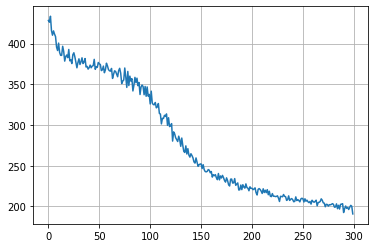

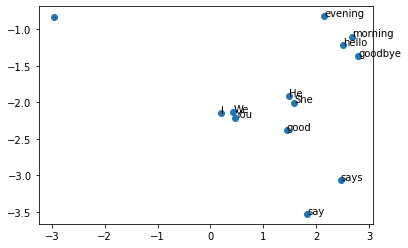

.	[-2.96338045 -0.83019494]
He	[ 1.48926631 -1.91398601]
I	[ 0.20491242 -2.14472673]
She	[ 1.58575027 -2.00457382]
We	[ 0.43125844 -2.13499646]
You	[ 0.46566676 -2.20796214]
evening	[ 2.15316705 -0.82355999]
good	[ 1.44820301 -2.38400499]
goodbye	[ 2.79548326 -1.37143072]
hello	[ 2.51369598 -1.21899863]
morning	[ 2.68492806 -1.10188966]
say	[ 1.82623858 -3.52597317]
says	[ 2.46821968 -3.06072249]


In [127]:
# 改良 CBOW
words = [
    'I', 'say', 'hello', '.',
    'I', 'say', 'goodbye', '.',
    'I', 'say', 'goodbye', '.',
    'I', 'say', 'good', 'morning', '.',
    'I', 'say', 'good', 'evening', '.',
    'You', 'say', 'hello', '.',
    'You', 'say', 'goodbye', '.',
    'You', 'say', 'good', 'morning', '.',
    'You', 'say', 'good', 'evening', '.',
    'We', 'say', 'hello', '.',
    'We', 'say', 'goodbye', '.',
    'We', 'say', 'good', 'morning', '.',
    'We', 'say', 'good', 'evening', '.',
    'He', 'says', 'hello', '.',
    'He', 'says', 'goodbye', '.',
    'He', 'says', 'good', 'morning', '.',
    'He', 'says', 'good', 'evening', '.',
    'She', 'says', 'hello', '.',
    'She', 'says', 'goodbye', '.',
    'She', 'says', 'good', 'morning', '.',
    'She', 'says', 'good', 'evening', '.'
]
cbow = CBOW(epochs=300, eta=0.1, hidden_size=2)
cbow.fit(words)

%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(range(len(cbow.loss)), cbow.loss)
plt.grid()
plt.show()
plt.scatter(cbow.layer1.W[:, 0], cbow.layer1.W[:, 1])
for i in range(len(cbow.id2word)):
    plt.annotate(cbow.id2word[i], (cbow.layer1.W[i][0], cbow.layer1.W[i][1]))
plt.show()

for i in range(len(cbow.id2word)):
    print('{}\t{}'.format(cbow.id2word[i], cbow.layer1.W[i]))